In [1]:
import micromagneticmodel as mm
import discretisedfield as df
import oommfc as oc
import matplotlib.pyplot as plt
import numpy as np
import micromagneticdata as md
from cycler import cycler
%matplotlib inline


In [ ]:
oc.runner.runner = oc.oommf.DockerOOMMFRunner()

In [2]:
l = 50e-9
w = 50e-9
l2 = 200e-9
region=df.Region(p1=(-l,-w,0),p2=(l2,w,3e-9))
subregions={'bottom':df.Region(p1=(-l,-w,0),p2=(l2,w,1e-9)),
            'spacer':df.Region(p1=(-l,-w,1e-9),p2=(l2,w,2e-9)),
            'top':df.Region(p1=(-l,-w,2e-9),p2=(l2,w,3e-9))}
cell=(2e-9,2e-9,1e-9)
mesh=df.Mesh(region=region,cell=cell,subregions=subregions)

In [3]:
Ms={'bottom':0.58e6,'spacer':0,'top':0.58e6}
A={'bottom':15e-12,'spacer':0,'top':15e-12}
D={'bottom':3e-3,'spacer':0,'top':3e-3}
def K_gai(pos):
    x,y,z=pos
    if 0 <= x <= 100e-9:
        return 0.8e6 + 0.12*1e6 * x/100e-9
    else:
        return 0.8e6
K=df.Field(mesh,dim=1,value=K_gai)

In [4]:
def m_init(pos):
    x,y,z=pos
    if 0 <= z < 1e-9:
        if ((x-150e-9)**2+y**2)**0.5 <= 15e-9:
            return (0,0,-1)
        else:
            return (0,0,1)
    else:
        if ((x-150e-9)**2+y**2)**0.5 <= 15e-9:
            return (0,0,1)
        else:
            return (0,0,-1)

In [ ]:
system = mm.System(name='diode')
system.energy = mm.Exchange(A=A)+mm.UniaxialAnisotropy(K=K,u=(0,0,1))\
            +mm.Demag()+mm.DMI(D=D,crystalclass='Cnv_z')\
            +mm.RKKY(sigma=-2e-3,sigma2=0,subregions=['bottom','top'])
system.dynamics = mm.Precession(gamma0=2.211e5)+mm.Damping(alpha=0.1)
system.m = df.Field(mesh,dim=3,value=m_init,norm=Ms)

In [ ]:
td=oc.TimeDriver()
td.drive(system,t=0.1e-9,n=10)

In [107]:
system.dynamics += mm.Slonczewski(J=25*(-1e10),mp=(0,1,0),P=0.4,Lambda=1,eps_prime=0)
td.drive(system,t=1e-9,n=60)

Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:30]... (222.6 s)


In [108]:
def system_fun(j0,t0):
    system = mm.System(name='diode')
    system.energy = mm.Exchange(A=A)+mm.UniaxialAnisotropy(K=K,u=(0,0,1))\
                +mm.Demag()+mm.DMI(D=D,crystalclass='Cnv_z')\
                +mm.RKKY(sigma=-2e-3,sigma2=0,subregions=['bottom','top'])
    system.dynamics = mm.Precession(gamma0=2.211e5)+mm.Damping(alpha=0.1)
    system.m = df.Field(mesh,dim=3,value=m_init,norm=Ms)
    td=oc.TimeDriver()
    td.drive(system,t=0.1e-9,n=10)
    system.dynamics += mm.Slonczewski(J=j0*(-1e10),mp=(0,1,0),P=0.4,Lambda=1,eps_prime=0)
    td.drive(system,t=t0*0.1e-9,n=50)

In [109]:
for i in range(8):
    system_fun(j0=i+26,t0=5)

Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:36]... (26.0 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:36]... (117.6 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:38]... (25.8 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:39]... (118.9 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:41]... (26.1 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:41]... (119.1 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:43]... (26.2 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:44]... (117.3 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:46]... (25.8 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:46]... (117.3 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:48]... (25.8 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:48]... (119.8 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:50]... (28.1 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:51]... (119.6 s)
Running OOMMF (DockerOOMMFRunner)[2022/07/09 17:53]... (25.4 s)
Running OOMMF (DockerOOMMFRunner)

In [59]:
td.drive(system,t=1e-9,n=40)

Running OOMMF (DockerOOMMFRunner)[2022/07/09 15:44]... (191.1 s)


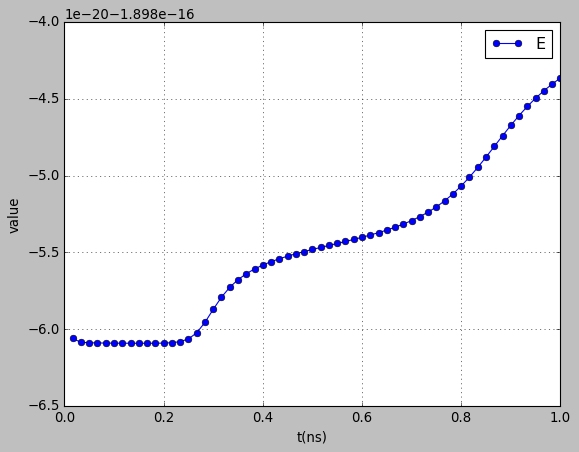

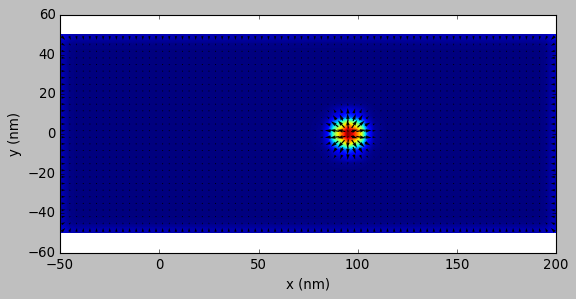

In [56]:
#能量磁矩图
plt.style.use('classic')
system.table.mpl(y=['E'],marker='o')
system.m.orientation.plane(z=25e-10,n=(75,30)).mpl(scalar_kw={'colorbar':False,
                                                        'interpolation':'bilinear'},
                                             vector_kw={'colorbar':False,
                                                        'scale':50})

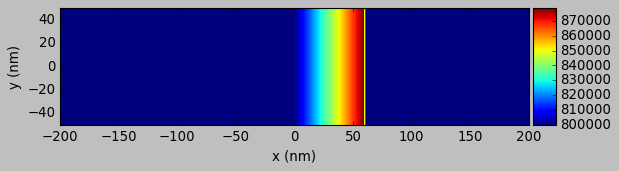

In [6]:
#查找文件
plt.style.use('classic')
df.Field.fromfile(r'f:\模拟文件2\wenzhang2\drive-19\uniaxialanisotropy_K.ovf').x.plane(z=3e-9).mpl.scalar()

In [96]:
#查找文件
data = md.Data(name='wenzhang2')
for i in range(data.n):
    if 'average_J' in data[i].table.units:
        J = data[i].table.data['average_J'][0]
        print(i, J/1e10)
    else:
        pass

1 6.0
2 6.0
4 -18.0
6 -18.0
8 -18.0
10 -18.0
12 -18.0
14 11.0
15 11.0
17 11.0
19 11.0
21 11.0
23 11.0
25 -20.0
27 7.0
29 8.0
30 8.0
32 8.0
34 8.0
36 8.0
38 8.0
40 10.0
42 3.0
44 -10.0
46 -20.0


In [131]:
#计算速度
data = md.Data(name='diode')
def cal_v(n):
    N = n
    X = []
    Y = []
    for i in range(data[N].n):
        m = data[N][i].orientation.plane(z=0)
        q = m @ (m.derivative('x') & m.derivative('y'))
        Q = df.integral(q * df.dx * df.dy) / (4 * np.pi)
        x = df.Field(data[N][i].plane(z=0).mesh, dim =1, value = lambda pos:pos[0])
        y = df.Field(data[N][i].plane(z=0).mesh, dim =1, value = lambda pos:pos[1])
        Rx = df.integral(x * q * df.dx * df.dy) / df.integral(q * df.dx * df.dy)
        Ry = df.integral(y * q * df.dx * df.dy) / df.integral(q * df.dx * df.dy)
        X.append(Rx*1e9)
        Y.append(Ry*1e9)
    t = data[N].table.data['t']*1e9
    delta_X = []
    delta_Y = []
    delta_T = []
    for i in range(len(X)-1):
        delta_x = X[i+1] - X[i]
        delta_X.append(delta_x)
    for i in range(len(Y)-1):
        delta_y = Y[i+1] - Y[i]
        delta_Y.append(delta_y)
    for i in range(len(t)-1):
        delta_t = t[i+1] - t[i]
        delta_T.append(delta_t)
    R = list(map(lambda x,y:np.sqrt(x**2+y**2),delta_X,delta_Y))
    v = list(map(lambda x,y: x/y,R,delta_T))
    print((sorted(v)[0],sorted(v[:20])[0]))

In [8]:
#merge table 计算速度
X = []
Y = []
for i in range(merge_table.n):
    m = merge_table[i].orientation.plane(z=0)
    q = m @ (m.derivative('x') & m.derivative('y'))
    Q = df.integral(q * df.dx * df.dy) / (4 * np.pi)
    x = df.Field(merge_table[i].plane(z=0).mesh, dim =1, value = lambda pos:pos[0])
    y = df.Field(merge_table[i].plane(z=0).mesh, dim =1, value = lambda pos:pos[1])
    Rx = df.integral(x * q * df.dx * df.dy) / df.integral(q * df.dx * df.dy)
    Ry = df.integral(y * q * df.dx * df.dy) / df.integral(q * df.dx * df.dy)
    X.append(Rx*1e9)
    Y.append(Ry*1e9)
t = merge_table.table.data['t']*1e9
delta_X = []
delta_Y = []
delta_T = []
for i in range(len(X)-1):
    delta_x = X[i+1] - X[i]
    delta_X.append(delta_x)
for i in range(len(Y)-1):
    delta_y = Y[i+1] - Y[i]
    delta_Y.append(delta_y)
for i in range(len(t)-1):
    delta_t = t[i+1] - t[i]
    delta_T.append(delta_t)
R = list(map(lambda x,y:np.sqrt(x**2+y**2),delta_X,delta_Y))
v = list(map(lambda x,y: x/y,R,delta_T))

In [2]:
#计算单个速度
data = md.Data(name='wenzhang2')
N = -1
X = []
Y = []
for i in range(data[N].n):
    m = data[N][i].orientation.plane(z=0)
    q = m @ (m.derivative('x') & m.derivative('y'))
    Q = df.integral(q * df.dx * df.dy) / (4 * np.pi)
    x = df.Field(data[N][i].plane(z=0).mesh, dim =1, value = lambda pos:pos[0])
    y = df.Field(data[N][i].plane(z=0).mesh, dim =1, value = lambda pos:pos[1])
    Rx = df.integral(x * q * df.dx * df.dy) / df.integral(q * df.dx * df.dy)
    Ry = df.integral(y * q * df.dx * df.dy) / df.integral(q * df.dx * df.dy)
    X.append(Rx*1e9)
    Y.append(Ry*1e9)
t = data[N].table.data['t']*1e9
delta_X = []
delta_Y = []
delta_T = []
for i in range(len(X)-1):
    delta_x = X[i+1] - X[i]
    delta_X.append(delta_x)
for i in range(len(Y)-1):
    delta_y = Y[i+1] - Y[i]
    delta_Y.append(delta_y)
for i in range(len(t)-1):
    delta_t = t[i+1] - t[i]
    delta_T.append(delta_t)
R = list(map(lambda x,y:np.sqrt(x**2+y**2),delta_X,delta_Y))
v = list(map(lambda x,y: x/y,R,delta_T))

In [3]:
#加速度
delta_V = []
for i in range(len(v)-1):
    delta_v = v[i+1] - v[i]
    delta_V.append(delta_v)
acc = list(map(lambda x,y: x/y,delta_V,delta_T[2:]))

In [7]:
#改变L
x0 = np.linspace(3,12,10)
y0 = np.array([2.5,18.3,34.7,50,65.2,80.3,95.5,110.6,125.9,140.9])
x2 = np.linspace(3,12,10)
y2 = [0,7.5,24,39.8,55.3,70.7,86.1,101.7,116.9,132.2]
x4 = np.linspace(5,14,10)
y4 = [3.4,19.6,36.7,53.4,69.4,85.2,101,116.8,132.8,148.9]
x6 = np.linspace(7,16,10)
y6 = [0,14.2,31.1,47.9,64.6,81.3,97.9,114.6,131.1,147.7]
x8 = np.linspace(10,19,10)
y8 = [0,10.3,27.5,45.2,62.1,80.4,97.6,114.8,132.4,149.9]

x1 = np.linspace(-15,-24,10)
y1 = -np.array([0,4.7,21.7,38.9,56.4,73.1,90.2,107.2,124.2,141])
x3 = np.linspace(-15,-24,10)
y3 = -np.array([0,8.1,25,42.3,59.5,76.9,94,111.6,128.7,145.6])
x5 = np.linspace(-15,-24,10)
y5 = -np.array([0,13.3,30.8,48.1,66.4,84.2,101.1,117.4,134.7,152.4])
x7 = np.linspace(-14,-23,10)
y7 = -np.array([0,6.9,24.2,41.7,58.9,76.6,94.3,111.2,128.9,146.5])
x9 = np.linspace(-12,-21,10)
y9 = -np.array([0,3.3,20.6,38.4,56.3,74.5,91.7,109.4,127,145])


X0 = np.stack([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9])
Y0 = np.stack([y0,y1,y2,y3,y4,y5,y6,y7,y8,y9])

In [8]:
#拟合曲线
x00 = np.insert(np.linspace(4,12,9),0,45.5/15.32)
x01 = np.insert(np.linspace(-16,-24,9),0,-268/17.1)
x02 = np.insert(np.linspace(4,12,9),0,57.6/15.32)
x03 = np.insert(np.linspace(-16,-24,9),0,-266/17.3)
x04 = np.insert(np.linspace(6,14,9),0,76.8/16.0)
x05 = np.insert(np.linspace(-16,-24,9),0,-260/17.3)
x06 = np.insert(np.linspace(8,16,9),0,121.4/16.5)
x07 = np.insert(np.linspace(-15,-23,9),0,-253/17.5)
x08 = np.insert(np.linspace(11,19,9),0,185.5/17.54)
x09 = np.insert(np.linspace(-13,-21,9),0,-225/17.6)

X1 = np.stack([x00,x01,x02,x03,x04,x05,x06,x07,x08,x09])

l0 = 15.32*X1[0] - 45.5
l1 = 17.1*X1[1] + 268
l2 = 15.32*X1[2] - 57.6
l3 = 17.3*X1[3] + 266
l4 = 16.0*X1[4] - 76.8
l5 = 17.3*X1[5] + 260
l6 = 16.5*X1[6] - 121.4
l7 = 17.5*X1[7] + 253
l8 = 17.54*X1[8] - 185.5
l9 = 17.6*X1[9] + 225

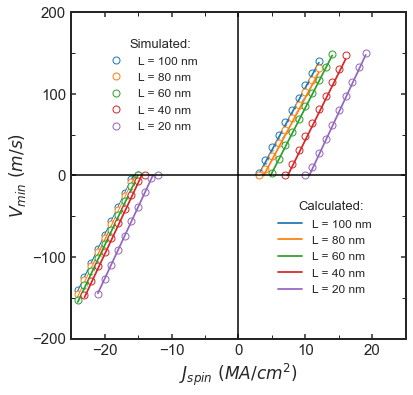

In [12]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
plt.style.use('seaborn-white')
custom_cycler = (cycler(color=['tab:blue']*4 + ['tab:orange']*4 + ['tab:green']*4 + ['tab:red']*4 + ['tab:purple']*4) +
                 cycler(markeredgecolor=['tab:blue']*4 + ['tab:orange']*4 + ['tab:green']*4 + ['tab:red']*4 + ['tab:purple']*4))
fig, ax = plt.subplots(figsize=(6,6))
ax.set_prop_cycle(custom_cycler)
for i in range(10):
    locals()['L'+str(i)], = ax.plot(X0[i],Y0[i],c='w',marker='o',markerfacecolor='w',markeredgewidth=1)
    locals()['Ln'+str(i)], = ax.plot(X1[i],locals()['l'+str(i)])
ax.plot(np.linspace(-27,25,10),[0]*10,c='k',lw=1.5)
ax.plot([0]*10,np.linspace(-200,200,10),c='k',lw=1.5)
ax.spines[['bottom','left','top','right']].set_lw(2)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(100))
ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax.set(ylim=(-200,200),xlim=(-25,25))
ax.set_xlabel(r'$J_{spin}\ (MA/{cm}^{2})$',fontsize=17)
ax.set_ylabel(r'$V_{min}\ (m/s)$',fontsize=17)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='both',which='minor',length=4,direction='in',width=1)
ax.tick_params(axis='both',which='major',length=5,direction='in',labelsize=15,width=1.5)
first_legend = ax.legend(bbox_to_anchor=(0.41,0.9),handles=[L0,L2,L4,L6,L8],labels=['L = {} nm'.format(i) for i in range(100,0,-20)],fontsize=12)
ax.add_artist(first_legend)
ax.legend(bbox_to_anchor=(0.93,0.4),handles=[Ln1,Ln3,Ln5,Ln7,Ln9],labels=['L = {} nm'.format(i) for i in range(100,0,-20)],fontsize=12)
ax.annotate('Simulated:',(0.3,0.805),xycoords='figure fraction',fontsize=13)
ax.annotate('Calculated:',(0.69,0.43),xycoords='figure fraction',fontsize=13)
plt.savefig('f:/tupian/wenzhang2/fuan.eps',dpi=600,bbox_inches='tight')
plt.show()

In [19]:
#改变delta K
x0 = np.linspace(1,10,10)
y0 = np.array([0,9.0,26.2,43.0,59.8,76.6,93.4,110.2,127.0,143.7])
x1 = np.linspace(-7,-16,10)
y1 = -np.array([0,5.7,23.3,41.4,59.5,77.4,95.8,113.2,130.5,149.2])

x2 = np.linspace(2,11,10)
y2 = np.array([0,13.6,30.4,46.5,62.5,78.5,94.5,110.4,126.4,142.3])
x3 = np.linspace(-11,-20,10)
y3 = -np.array([0,6.0,23.2,40.7,57.8,75.6,93.3,111.1,129.0,147.0])

x4 = np.linspace(3,12,10)
y4 = np.array([1.5,18.3,34.7,50,65.2,80.3,95.5,110.6,125.9,140.9])
x5 = np.linspace(-15,-24,10)
y5 = -np.array([0,4.7,21.7,38.9,56.4,73.7,90.2,107.2,125.2,142.2])

x6 = np.linspace(3,12,10)
y6 = np.array([0,6.5,23,39,53.4,67.7,82,96.2,110.4,124.7])
x7 = np.linspace(-19,-28,10)
y7 = -np.array([0,1.9,18.3,34.9,51.8,68.6,86,103.7,121.1,138.5])

x8 = np.linspace(4,13,10)
y8 = np.array([0,10.5,27.2,43,56.4,69.7,83.0,96.2,109.3,122.6])
x9 = np.linspace(-24,-33,10)
y9 = -np.array([0,13.6,29.7,46.2,63.3,79.8,97.4,113.4,129.6,145.8])

X0 = np.stack([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9])
Y0 = np.stack([y0,y1,y2,y3,y4,y5,y6,y7,y8,y9])

In [52]:
#拟合曲线
x00 = np.insert(np.linspace(2,10,9),0,26/16.5)
x01 = np.insert(np.linspace(-8,-16,9),0,-139/18.1)
x02 = np.insert(np.linspace(3,11,9),0,36.1/16.4)
x03 = np.insert(np.linspace(-12,-20,9),0,-205/17.5)
x04 = np.insert(np.linspace(4,12,9),0,45.5/15.1)
x05 = np.insert(np.linspace(-16,-24,9),0,-268/17.3)
x06 = np.insert(np.linspace(4,12,9),0,51.6/14.5)
x07 = np.insert(np.linspace(-20,-28,9),0,-338/17.2)
x08 = np.insert(np.linspace(5,13,9),0,55.5/13.6)
x09 = np.insert(np.linspace(-25,-33,9),0,-408/17.0)

X1 = np.stack([x00,x01,x02,x03,x04,x05,x06,x07,x08,x09])

l0 = 16.5*X1[0]-26.0
l1 = 18.1*X1[1]+139
l2 = 16.4*X1[2]-36.1
l3 = 17.5*X1[3]+205
l4 = 15.1*X1[4]-45.5
l5 = 17.3*X1[5]+268
l6 = 14.5*X1[6]-51.6
l7 = 17.2*X1[7]+338
l8 = 13.6*X1[8]-55.5
l9 = 17.0*X1[9]+408

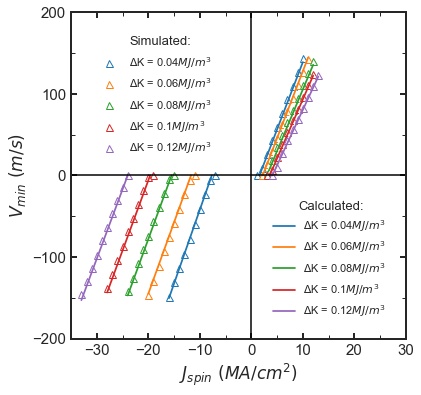

In [62]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
plt.style.use('seaborn-white')
custom_cycler = (cycler(color=['tab:blue']*4 + ['tab:orange']*4 + ['tab:green']*4 + ['tab:red']*4 + ['tab:purple']*4) +
                 cycler(markeredgecolor=['tab:blue']*4 + ['tab:orange']*4 + ['tab:green']*4 + ['tab:red']*4 + ['tab:purple']*4))
fig, ax = plt.subplots(figsize=(6,6))
ax.set_prop_cycle(custom_cycler)
for i in range(10):
    locals()['L'+str(i)], = ax.plot(X0[i],Y0[i],c='w',marker='^',markerfacecolor='w',markeredgewidth=1)
    locals()['Ln'+str(i)], = ax.plot(X1[i],locals()['l'+str(i)])
ax.plot(np.linspace(-35,30,10),[0]*10,c='k',lw=1.5)
ax.plot([0]*10,np.linspace(-200,200,10),c='k',lw=1.5)
ax.spines[['bottom','left','top','right']].set_lw(2)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(100))
ax.yaxis.set_minor_locator(plt.MultipleLocator(50))
ax.set(ylim=(-200,200),xlim=(-35,30))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='both',which='minor',length=4,direction='in',width=1)
ax.tick_params(axis='both',which='major',length=5,direction='in',labelsize=15,width=1)
ax.set_xlabel(r'$J_{spin}\ (MA/{cm}^{2})$',fontsize=17)
ax.set_ylabel(r'$V_{min}\ (m/s)$',fontsize=17)
ax.tick_params(length=6,width=2,direction='in',labelsize=15)
first_legend = ax.legend(bbox_to_anchor=(0.45,0.9),handles=[L0,L2,L4,L6,L8],labels=['{}K = {}{}'.format(chr(916),i,r'$MJ/m^{3}$') for i in np.around(np.linspace(0.04,0.12,5),2)],fontsize=11)
ax.add_artist(first_legend)
ax.legend(bbox_to_anchor=(0.97,0.4),handles=[Ln1,Ln3,Ln5,Ln7,Ln9],labels=['{}K = {}{}'.format(chr(916),i,r'$MJ/m^{3}$') for i in np.around(np.linspace(0.04,0.12,5),2)],fontsize=11)
ax.annotate('Simulated:',(0.3,0.81),xycoords='figure fraction',fontsize=13)
ax.annotate('Calculated:',(0.69,0.43),xycoords='figure fraction',fontsize=13)
plt.savefig('f:/tupian/wenzhang2/fuan1.eps',dpi=600,bbox_inches='tight')
plt.show()

In [88]:
Z0 = np.polyfit(X0[1][1:],Y0[1][1:],1)
Z1 = np.polyfit(X0[3][1:],Y0[3][1:],1)
Z2 = np.polyfit(X0[5][1:],Y0[5][1:],1)
Z3 = np.polyfit(X0[7][1:],Y0[7][1:],1)
Z4 = np.polyfit(X0[9][1:],Y0[9][1:],1)
P0 = np.poly1d(Z0)
P1 = np.poly1d(Z1)
P2 = np.poly1d(Z2)
P3 = np.poly1d(Z3)
P4 = np.poly1d(Z4)
print(P0,P1,P2,P3,P4)

 
17.05 x + 268  
17.24 x + 267.9  
17.36 x + 264  
17.45 x + 254.9  
17.72 x + 227.3


In [34]:
l0 = 19*X0[0][1:]-30
l1 = 19*X0[1][1:]+145
l2 = 19*X0[2][1:]-45
l3 = 19*X0[3][1:]+225
l4 = 19*X0[4][1:]-60
l5 = 19*X0[5][1:]+300
l6 = 19*X0[6][1:]-75
l7 = 19*X0[7][1:]+375
l8 = 18*X0[8][1:]-85
l9 = 19*X0[9][1:]+460
for i in range(10):
    np.insert(locals()['l'+str(i)],0,0)

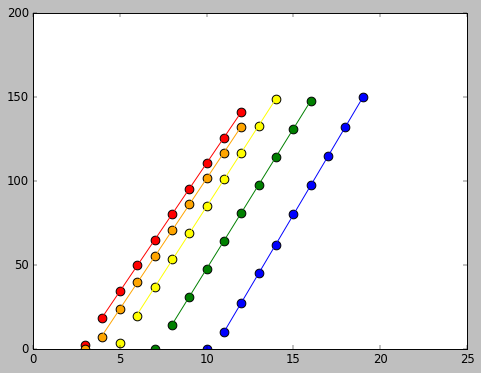

In [70]:
plt.style.use('classic')
fig, ax = plt.subplots(dpi=70)
ax.scatter(X0[0],Y0[0],c='r',s=80)
ax.scatter(X0[2],Y0[2],c='orange',s=80)
ax.scatter(X0[4],Y0[4],c='yellow',s=80)
ax.scatter(X0[6],Y0[6],c='green',s=80)
ax.scatter(X0[8],Y0[8],c='blue',s=80)
ax.plot(X0[0][1:],P0(X0[0][1:]),c='r')
ax.plot(X0[2][1:],P1(X0[2][1:]),c='orange')
ax.plot(X0[4][1:],P2(X0[4][1:]),c='yellow')
ax.plot(X0[6][1:],P3(X0[6][1:]),c='green')
ax.plot(X0[8][1:],P4(X0[8][1:]),c='blue')
ax.set(xlim=(0,25),ylim=(0,200))
plt.show()

In [5]:
#计算斯格明子尺寸（不精确）
list_a = []
for i in range(data[-1].n):
    px = data[-1][i].orientation.line(p1=(-200e-9,0,0),p2=(200e-9,0,0),n=200).data['px']*1e9
    vz = data[-1][i].orientation.line(p1=(-200e-9,0,0),p2=(200e-9,0,0),n=200).data['vz']
    dic = dict(zip(px,vz))
    a = sorted(dic.items(), key = lambda d: d[1])[0][0]
    list_a.append(a)